# Pruning a Dense-Network with MNIST

---

Please take a look at the `README` for sources and references.

## Imports and Data-Preparation

In [2]:
## Settings
model_type = "LeNet5"  ## Choice of "LeNet5" and "Dense"

In [3]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Importing Pruned Model
import sys; 
if "..\\" not in sys.path: sys.path.append("..\\")
from src.masked_keras import MaskedModel
import src.wrappers as wrp

In [4]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = wrp.load_mnist()
num_classes = 10

In [5]:
if model_type == "LeNet5":
    X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_test  = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

---

## Defining the Model, Loss, and Optimizer

In [6]:
## Defining the Model with Sequential API
if model_type == "Dense":
    model = keras.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

if model_type == "LeNet5":
    model = keras.Sequential([
        layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', 
            input_shape=X_train.shape[1:]),
        layers.AveragePooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
        layers.AveragePooling2D(),
        layers.Flatten(),
        layers.Dense(units=120, activation='relu'),
        layers.Dense(units=84, activation='relu'),
        layers.Dense(units=10, activation = 'softmax')
    ])

## Extract init-model weights for training after pruning
w_init = model.get_weights().copy()

In [7]:
loss_fn = keras.losses.CategoricalCrossentropy()
metrics = [
    keras.metrics.TopKCategoricalAccuracy(
        k=1, name="categorical_accuracy", dtype=None), 
    keras.metrics.CategoricalCrossentropy()]

In [8]:
print(f"Accuracy at init: {wrp.simple_accuracy(model, X_test, y_test)}")

Accuracy at init: 0.12399999797344208


---

## Pruning Step

Pruning logic from [Alizadeh, et al. (2022)](https://arxiv.org/pdf/2202.08132.pdf), but taking care of the pruning step-wise. Custom training loop modified from [Géron (2019)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). 

In [9]:
meta_gradients, prune_fit_history = wrp.prune_loop(
    model=model,
    X_train=X_train, y_train=y_train,
    loss_fn=loss_fn,
    metrics=metrics,
    prune_lr=0.05,
    validation_data=(X_test, y_test))

Epoch 1/1
60000/60000 - categorical_accuracy: 0.7146 - categorical_crossentropy: 0.9180


In [10]:
X_M, y_M = wrp.random_batch(X_train, y_train, batch_size=128)
saliency_scores = wrp.compute_saliency_scores(
    meta_gradients=meta_gradients,
    model=model,
    X_train=X_M, y_train=y_M,
    loss_fn=loss_fn)

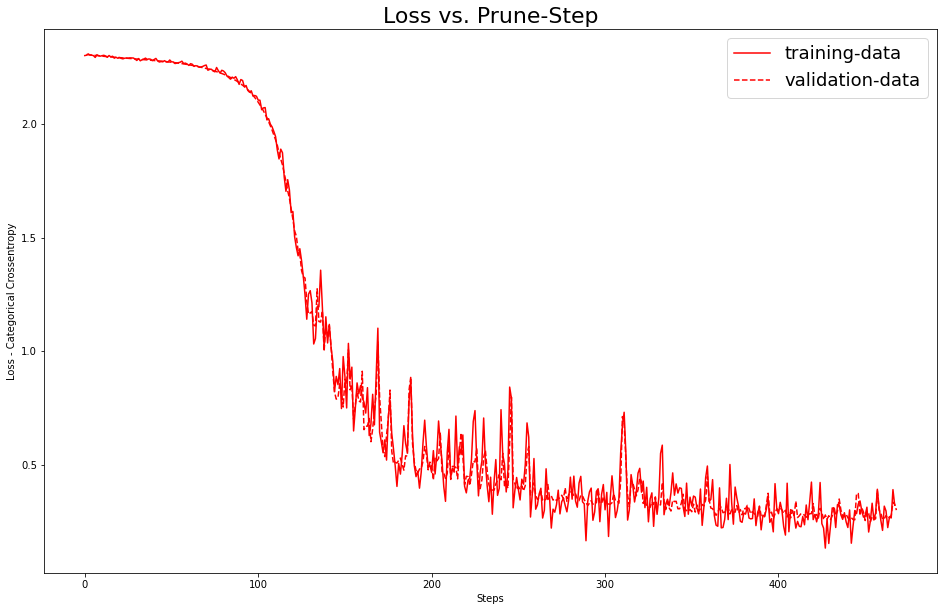

In [13]:
_ = wrp.visualize_prune_history(prune_fit_history)

---

## Train Pruned Model

In [14]:
masks = wrp.generate_pruning_mask(saliency_scores)

In [15]:
pruned_model = MaskedModel(masks, keras.models.clone_model(model))
pruned_model.set_weights(w_init)
print(f"Accuracy at init: {wrp.simple_accuracy(model, X_test, y_test)}")

Accuracy at init: 0.11349999904632568


In [16]:
pruned_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss_fn,
    metrics=["accuracy"]
)

In [17]:
pruned_fit = pruned_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1,
    batch_size=128
)

469/469 [==============================] - 3s 5ms/step - loss: 0.6044 - accuracy: 0.8704 - val_loss: 0.2651 - val_accuracy: 0.9210


In [18]:
with tf.GradientTape() as tape:
    y_pred = pruned_model(X_test)
    loss = loss_fn(y_test, y_pred)
gradients = tape.gradient(loss, pruned_model.trainable_variables)

In [19]:
## Sanity Check
weights_flat = np.concatenate([w.flatten() for w in pruned_model.get_weights()])
masks_flat   = np.concatenate([mask.numpy().flatten() for mask in masks])
grads_flat = np.concatenate([grad.numpy().flatten() for grad in gradients])

weights_zero = np.isclose(weights_flat, 0)
masks_zero = np.isclose(masks_flat, 0)
grads_zero = np.isclose(grads_flat, 0)

print(np.mean(weights_zero == masks_zero))
print(np.mean(grads_zero == masks_zero))

0.9999876838190014
0.27973741902110993


---

## Sparsity vs. Accuracy

In [20]:
## Saliency Pruning
sparsity_range = np.linspace(0.9, 1., 20)

accuracy = []
loss = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_pruning_mask(
        saliency_scores, 
        sparsity=np.clip(sparsity, a_min=0., a_max=1.))
    pruned_model = MaskedModel(masks, keras.models.clone_model(model))
    pruned_model.set_weights(w_init)

    pruned_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = pruned_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy.append(pruned_fit.history['val_accuracy'])
    loss.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:53<00:00,  2.68s/it]


In [28]:
## Random Pruning
weight_shapes = [var.shape for var in model.trainable_weights]

accuracy_random = []
loss_random = []

for sparsity in tqdm(sparsity_range):
    masks = wrp.generate_random_pruning_mask(
        weight_shapes, 
        sparsity=sparsity)
    pruned_model = MaskedModel(masks, keras.models.clone_model(model))
    pruned_model.set_weights(w_init)

    pruned_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    pruned_fit = pruned_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        verbose=0,
        epochs=1,
        batch_size=128
    )

    accuracy_random.append(pruned_fit.history['val_accuracy'])
    loss_random.append(pruned_fit.history['val_loss'])

100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


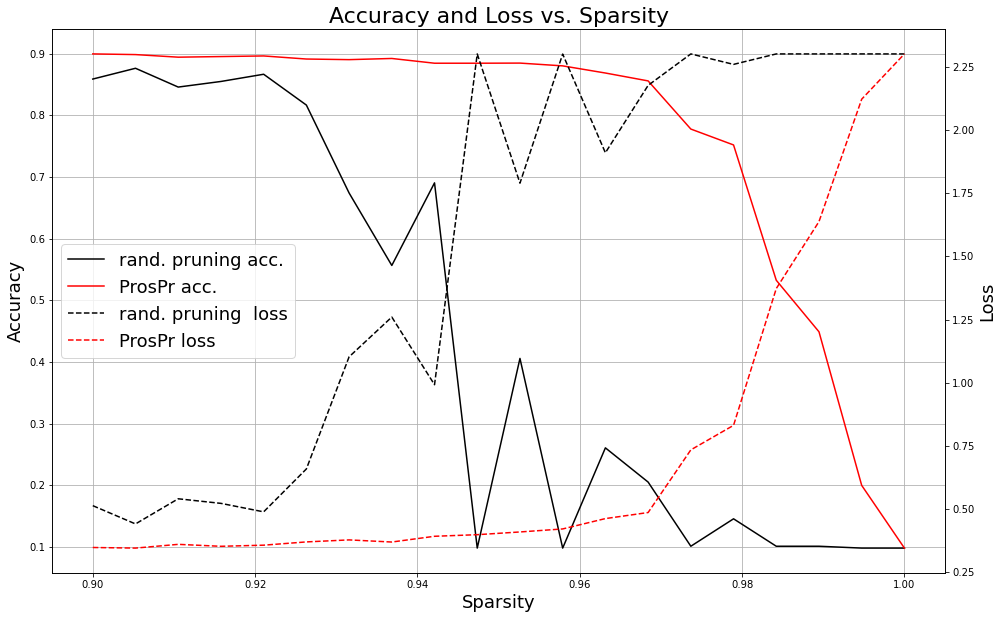

In [29]:
fig, ax0 = plt.subplots(figsize=(16, 10))
ax1 = ax0.twinx()
ax0.set_title("Accuracy and Loss vs. Sparsity", fontsize=22)
ln0 = ax0.plot(sparsity_range, accuracy_random, "k-",  label="rand. pruning acc.") 
ln1 = ax0.plot(sparsity_range, accuracy, "r-",  label="ProsPr acc.") 
ln2 = ax1.plot(sparsity_range, loss_random,     "k--", label="rand. pruning  loss")
ln3 = ax1.plot(sparsity_range, loss,     "r--", label="ProsPr loss") 
ax1.set_ylabel("Loss", fontsize=18)
ax0.set_xlabel("Sparsity", fontsize=18)
ax0.set_ylabel("Accuracy", fontsize=18)
ax0.grid()
lns = ln0 + ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', fontsize=18)
plt.show()
plt.close()